In [1]:
import gc
from datetime import datetime
import numpy as np
import pandas as pd
from lib.stats import probs_from_samples, pdf_from_samples

In [2]:
EXECUTION_NAME = datetime.now().replace(second=0, microsecond=0).isoformat()
PREPROCESSING_EXECUTION_NAME = "2024-06-09T18:27:00"
OUTPUT_PATH = '../data/'
EXECUTION_DURATION_S = 14*24*60*60; NS_TO_S = 1000000000
RANDOM_GEN = np.random.default_rng(seed=42)
PERCENTILES = [.5,.75,.9,.95,.99,.999]

In [3]:
DF = pd.read_csv(OUTPUT_PATH+PREPROCESSING_EXECUTION_NAME+'-EVENTS.csv.gz',
                 index_col='id')

In [4]:
DF

,app_id,func_id,end_ns,dur_ns,beg_ns,ts,req_id,event_type
id,,,,,,,,
0,8,63,79490900,78000000,1490900,1490900,0,1
1,64,150,57157860040,57154000000,3860040,3860040,1,1
2,64,146,59130477905,59125000000,5477905,5477905,2,1
3,0,245,6252541065,6236000000,16541065,16541065,3,1
4,8,374,66823959,50000000,16823959,16823959,4,1
...,...,...,...,...,...,...,...,...
3961897,19,376,1209598561518907,1000000,1209598560518907,1209598561518907,1980948,0
3961898,19,376,1209598628381967,1000000,1209598627381967,1209598627381967,1980949,1
3961899,19,376,1209598628381967,1000000,1209598627381967,1209598628381967,1980949,0


In [5]:
_count = -1
_app_id = -1
def get_count(app_id):
    global _count,_app_id
    if app_id == _app_id:
        _count += 1
    else:
        _count = 0
        _app_id = app_id
    return _count

In [6]:
def state_fabric():
    return {'current_requests': set(),
             'last_arrival_ts': 0,
             'last_departure_ts': 0,
             'last_event_ts': 0,
             'avg_active_count': 0,
             'activity_pc': 0,
             'idle_arrival_count': 0, 
             'duration': [],
             'active_count': dict(),
             'arrival_ts': [],
             'arrival_dt': [],
             'departure_dt': [],
             'arrival_departure_dt': [],
             'departure_arrival_dt': []}
def update_state(event, state):
    req_cnt = len(state['current_requests'])
    if req_cnt != 0:
        eventDt = event.ts - state['last_event_ts']
        state['avg_active_count'] += req_cnt*eventDt
        if req_cnt in state['active_count']:
            state['active_count'][req_cnt] += eventDt
        else:
            state['active_count'][req_cnt] = eventDt
        state['activity_pc'] += eventDt 
    if event.event_type == 1:
        state['arrival_ts'].append(event.ts)
        state['arrival_dt'].append(event.ts - state['last_arrival_ts'])
        state['departure_arrival_dt'].append(event.ts - state['last_departure_ts'])
        if len(state['current_requests']) != 0:
            state['idle_arrival_count'] += 1
        state['current_requests'].add(event.req_id)
        state['last_arrival_ts'] = event.ts
    else:
        state['departure_dt'].append(event.ts - state['last_departure_ts'])
        state['arrival_departure_dt'].append(event.ts - state['last_arrival_ts'])
        state['current_requests'].remove(event.req_id)
        state['last_departure_ts'] = event.ts
        state['duration'].append(event.dur_ns)
    state['last_event_ts'] = event.ts
def normalize_state(state):
    state['activity_pc'] /= (EXECUTION_DURATION_S*NS_TO_S)
    state['avg_active_count'] /= (state['activity_pc']*EXECUTION_DURATION_S*NS_TO_S)

In [7]:
STATE = {
    "global": state_fabric(),
    "app":dict(
        [*[app_id, state_fabric()]]
        for app_id in DF["app_id"].unique()),
    "func":dict(
        [*[func_id, state_fabric()]]
        for func_id in DF["func_id"].unique()),
}
for event in DF.itertuples():
    update_state(event, STATE["func"][event.func_id])
    update_state(event, STATE["app"][event.app_id])
    update_state(event, STATE["global"])
for state in STATE['func'].values():
    normalize_state(state)
for state in STATE['app'].values():
    normalize_state(state)
normalize_state(STATE['global'])

In [8]:
def aggregate_state(key):
    return {
        'avg_active_count': pd.Series(np.vectorize(lambda stt: stt['avg_active_count'])(tuple(STATE[key].values()))),
        'activity_pc': pd.Series(np.vectorize(lambda stt: stt['activity_pc'])(tuple(STATE[key].values()))),
        'idle_arrival_count': pd.Series(np.vectorize(lambda stt: stt['idle_arrival_count'])(tuple(STATE[key].values()))),
        'duration': pd.Series(np.concatenate(tuple(map(lambda stt: stt['duration'], tuple(STATE[key].values()))))),
        'arrival_ts': pd.Series(np.concatenate(tuple(map(lambda stt: stt['arrival_ts'], tuple(STATE[key].values()))))),
        'arrival_dt': pd.Series(np.concatenate(tuple(map(lambda stt: stt['arrival_dt'], tuple(STATE[key].values()))))),
        'departure_dt': pd.Series(np.concatenate(tuple(map(lambda stt: stt['departure_dt'], tuple(STATE[key].values()))))),
        'arrival_departure_dt': pd.Series(np.concatenate(tuple(map(lambda stt: stt['arrival_departure_dt'], tuple(STATE[key].values()))))),
        'departure_arrival_dt': pd.Series(np.concatenate(tuple(map(lambda stt: stt['departure_arrival_dt'], tuple(STATE[key].values()))))),
    }

In [24]:
STATE_APP = aggregate_state('app')
STATE_FUNC = aggregate_state('func')
for col in ['duration','arrival_dt','departure_dt','arrival_departure_dt','departure_arrival_dt']:
    STATE['global'][col] = pd.Series(STATE['global'][col])
STATE_GLOBAL = STATE['global']

     'avg_active_count': 0,
             'activity_pc': 0,
             'idle_arrival_count': 0,
             'duration': [],
             'arrival_ts': [],
             'arrival_dt': [],
             'departure_dt': [],
             'arrival_departure_dt': [],
             'departure_arrival_dt': []


In [17]:
def prob_analysis(state: dict, xlog):
    for col in ['duration','arrival_dt','departure_dt','arrival_departure_dt','departure_arrival_dt']:
        desc = (state[col]/NS_TO_S).describe(percentiles=PERCENTILES)
        xr = float(desc["95%"])
        print(col)
        print(desc)
        print(xr)
        probs_from_samples((state[col]/NS_TO_S).values,1000,0,xr,True,xlog,42)

In [38]:
from sklearn.neighbors import KernelDensity
from matplotlib import pyplot as plt

def pdf_from_samples(xs: np.ndarray, xl: float = None, xr: float = None, n_samples: int = 100, kernel='gaussian',
                     bandwidth='silverman', random_state=None) -> (np.ndarray, np.ndarray, KernelDensity):
    if xl is None:
        xl = min(xs)
    if xr is None:
        xr = max(xs)
    kde = KernelDensity(bandwidth=bandwidth, kernel=kernel).fit(xs.reshape(-1, 1))
    X_d = np.array([])
    while len(X_d) < n_samples:
        x_d: np.ndarray = np.random.choice(xs, n_samples)
        x_d = x_d[xl <= x_d]
        x_d = x_d[xr >= x_d]
        X_d = np.append(X_d, x_d)
    X_d.sort()
    Y_d = np.exp(kde.score_samples(X_d.reshape(-1, 1))).reshape(len(X_d))
    return X_d, Y_d, kde


def cdf_from_pdf(xs: np.ndarray, ys: np.ndarray):
    ret = np.cumsum(
        np.append(0, np.vectorize(lambda i: (xs[i + 1] - xs[i]) * (ys[i + 1] + ys[i]) / 2)(range(len(xs) - 1))))
    return ret / ret[-1]


def probs_from_samples(samples: np.ndarray, n_size: int, xl: float = None, xr: float = None, plot: bool = True,
                       plot_xlog: bool = False, random_state: int = None, kernel: str = 'tophat'):
    if xl is None:
        xl = min(samples)
    if xr is None:
        xr = max(samples)
    X_d, Y_d, kde = pdf_from_samples(samples, xl=xl, xr=xr, n_samples=n_size, random_state=random_state, kernel=kernel,
                                     bandwidth='silverman')
    Y_c = cdf_from_pdf(X_d, Y_d)
    if plot:
        plot_area(X_d, Y_d, plot_xlog)
        plot_area(X_d, Y_c, plot_xlog)
    return X_d, Y_d, Y_c


def plot_area(xs, ys, xlog=False):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    if xlog:
        plt.xscale('log', base=10)
    else:
        plt.xscale('linear')
    ax.fill_between(xs, ys)
    plt.show(fig)


In [57]:
(STATE_FUNC['arrival_dt']/NS_TO_S).describe(percentiles=PERCENTILES)


count    1.980951e+06
mean     2.033429e+02
std      9.440685e+03
min      0.000000e+00
50%      4.944449e-01
75%      2.079858e+00
90%      1.766323e+01
95%      1.199537e+02
99%      3.002303e+02
99.9%    1.921025e+04
max      1.181683e+06
dtype: float64

count    1.980951e+06
mean     2.033429e+02
std      9.440685e+03
min      0.000000e+00
50%      4.944449e-01
75%      2.079858e+00
90%      1.766323e+01
95%      1.199537e+02
99%      3.002303e+02
99.9%    1.921025e+04
max      1.181683e+06
dtype: float64

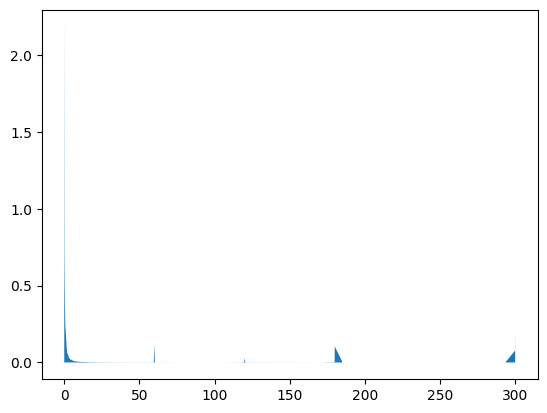

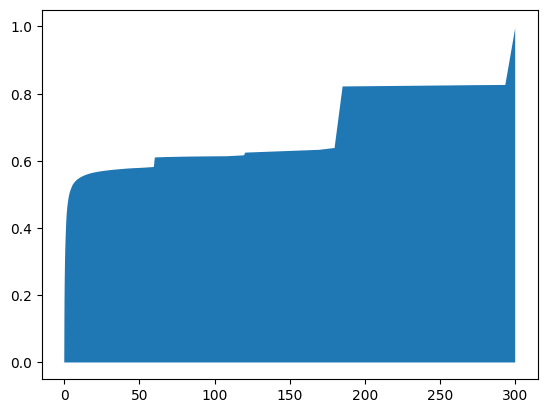

In [106]:
    probs_from_samples((STATE_FUNC['arrival_dt']/NS_TO_S).values,xl=0,xr=350,n_size=700,plot=True,plot_xlog=False,random_state=420, kernel='epanechnikov');

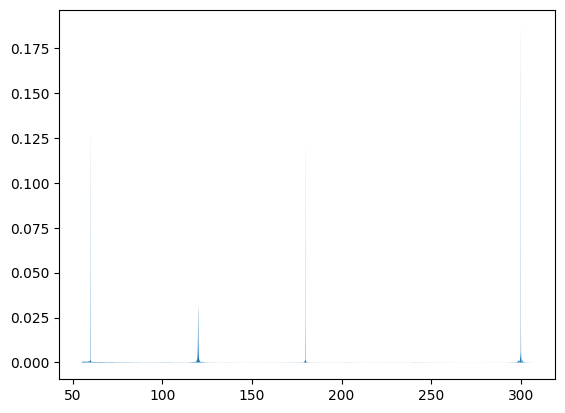

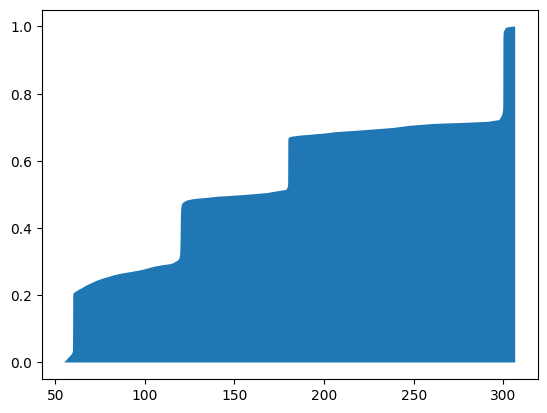

In [105]:
    probs_from_samples((STATE_FUNC['arrival_dt']/NS_TO_S).values,xl=55,xr=320,n_size=700,plot=True,plot_xlog=False,random_state=420, kernel='epanechnikov');


In [72]:
STATE_FUNC['avg_active_count'].describe(percentiles=PERCENTILES)

count    424.000000
mean       4.101084
std       17.091401
min        1.000000
50%        1.000000
75%        1.007802
90%        2.550142
95%        9.789169
99%       81.948330
99.9%    172.666687
max      181.605385
dtype: float64

count    424.000000
mean       4.101084
std       17.091401
min        1.000000
50%        1.000000
75%        1.007802
90%        2.550142
95%        9.789169
99%       81.948330
99.9%    172.666687
max      181.605385
dtype: float64

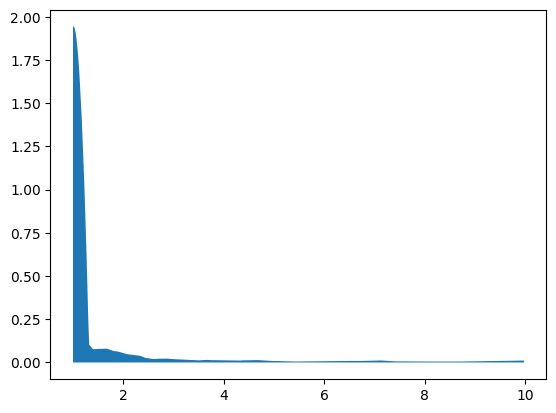

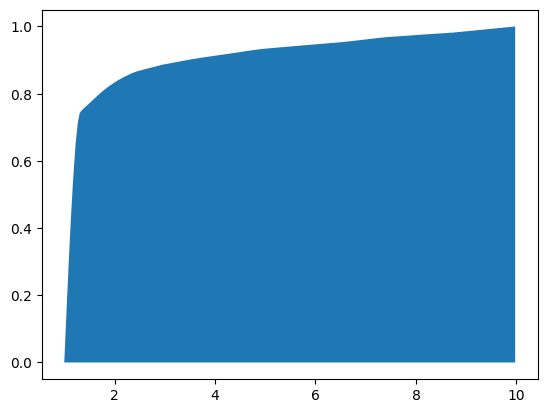

In [107]:
    probs_from_samples((STATE_FUNC['avg_active_count']).values,xl=0,xr=10,n_size=700,plot=True,plot_xlog=False,random_state=420, kernel='epanechnikov');


In [82]:
(STATE_FUNC['activity_pc']).describe(percentiles=PERCENTILES)

count    4.240000e+02
mean     4.238817e-03
std      2.243570e-02
min      7.440476e-09
50%      1.377397e-05
75%      4.779404e-04
90%      3.416821e-03
95%      1.124502e-02
99%      1.457883e-01
99.9%    2.319253e-01
max      2.332423e-01
dtype: float64

count    4.240000e+02
mean     4.238817e-03
std      2.243570e-02
min      7.440476e-09
50%      1.377397e-05
75%      4.779404e-04
90%      3.416821e-03
95%      1.124502e-02
99%      1.45                                                                                                                                                                                                                                                                                                                                                                                   7883e-01
99.9%    2.319253e-01
max      2.332423e-01
dtype: float64

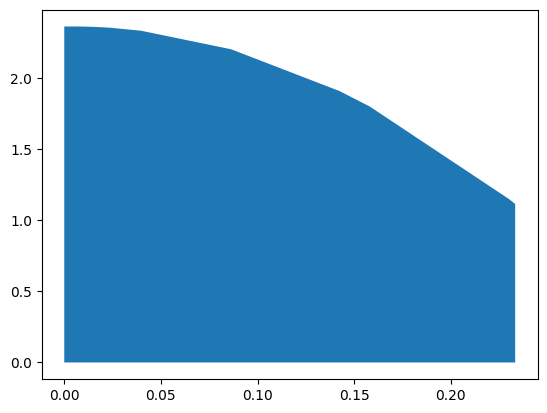

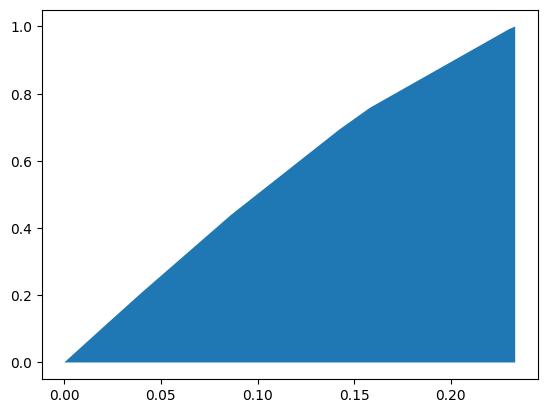

In [108]:
probs_from_samples((STATE_FUNC['activity_pc']).values,xl=0,xr=.24,n_size=700,plot=True,plot_xlog=False,random_state=420, kernel='epanechnikov');

In [90]:
(STATE_FUNC['arrival_departure_dt']/NS_TO_S).describe(percentiles=PERCENTILES)

count    1.980951e+06
mean     1.623593e+00
std      1.330648e+01
min      0.000000e+00
50%      2.500000e-02
75%      2.510000e-01
90%      8.490000e-01
95%      2.490000e+00
99%      5.086391e+01
99.9%    1.684019e+02
max      5.786200e+02
dtype: float64

count    1.980951e+06
mean     1.623593e+00
std      1.330648e+01
min      0.000000e+00
50%      2.500000e-02
75%      2.510000e-01
90%      8.490000e-01
95%      2.490000e+00
99%      5.086391e+01
99.9%    1.684019e+02
max      5.786200e+02
dtype: float64

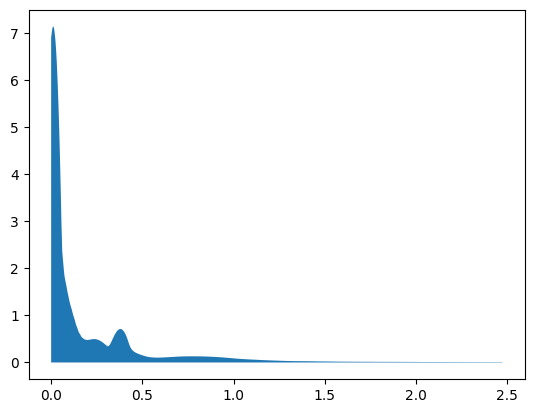

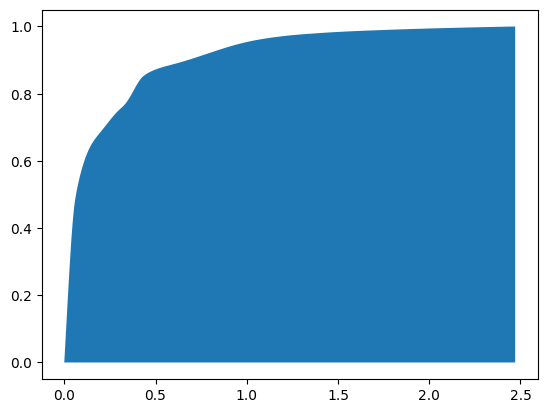

In [109]:
probs_from_samples((STATE_FUNC['arrival_departure_dt']/NS_TO_S).values,xl=0,xr=2.49,n_size=700,plot=True,plot_xlog=False,random_state=420, kernel='epanechnikov');

In [94]:
(STATE_FUNC['departure_arrival_dt']/NS_TO_S).describe(percentiles=PERCENTILES)

count    1.980951e+06
mean     3.926487e+02
std      1.467447e+04
min      9.000000e-09
50%      4.778671e-01
75%      2.124388e+00
90%      2.130885e+01
95%      1.434246e+02
99%      1.132574e+03
99.9%    4.588664e+04
max      1.181683e+06
dtype: float64

count    1.980951e+06
mean     3.926487e+02
std      1.467447e+04
min      9.000000e-09
50%      4.778671e-01
75%      2.124388e+00
90%      2.130885e+01
95%      1.434246e+02
99%      1.132574e+03
99.9%    4.588664e+04
max      1.181683e+06
dtype: float64

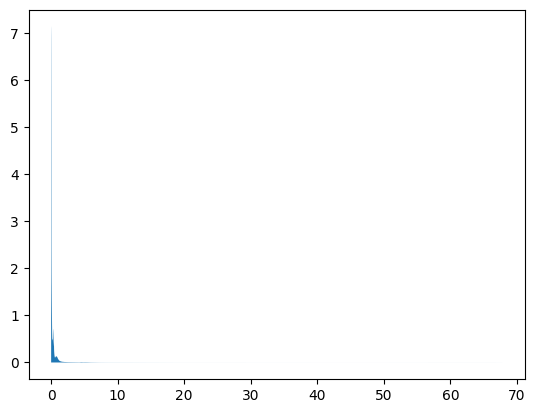

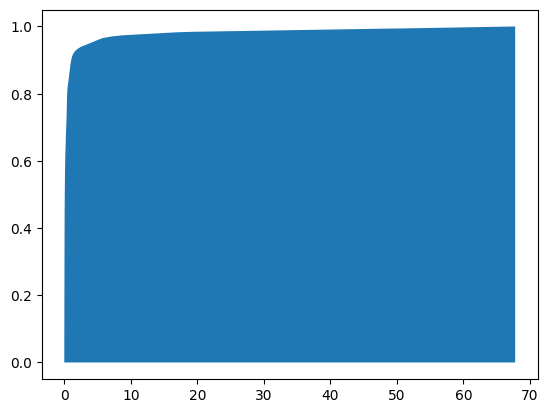

In [110]:
probs_from_samples((STATE_FUNC['arrival_departure_dt']/NS_TO_S).values,xl=0,xr=143.5,n_size=700,plot=True,plot_xlog=False,random_state=420, kernel='epanechnikov');

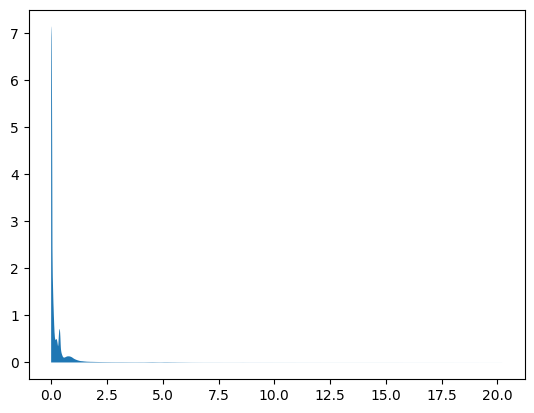

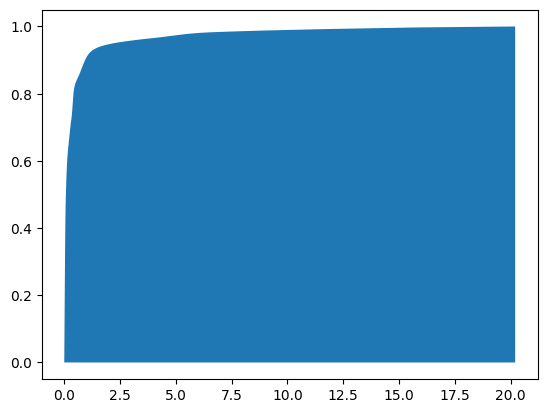

In [111]:
 probs_from_samples((STATE_FUNC['arrival_departure_dt']/NS_TO_S).values,xl=0,xr=21.30885,n_size=700,plot=True,plot_xlog=False,random_state=420, kernel='epanechnikov');

In [97]:
(STATE_FUNC['departure_dt']/NS_TO_S).describe(percentiles=PERCENTILES)

count    1.980951e+06
mean     2.033449e+02
std      9.440798e+03
min      0.000000e+00
50%      4.969530e-01
75%      2.084878e+00
90%      1.769767e+01
95%      1.199498e+02
99%      3.103511e+02
99.9%    1.921118e+04
max      1.181684e+06
dtype: float64

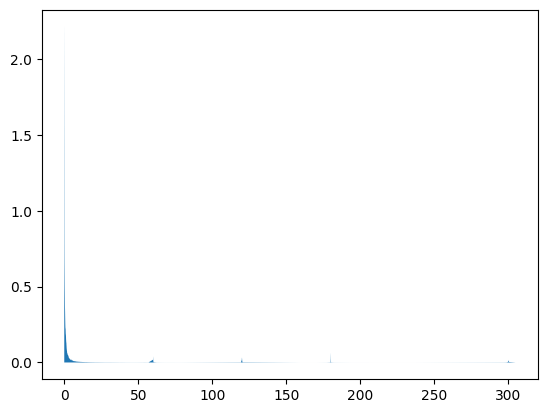

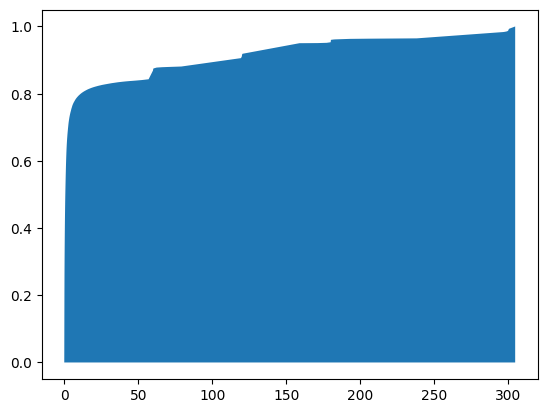

In [112]:
 probs_from_samples((STATE_FUNC['departure_dt']/NS_TO_S).values,xl=0,xr=311.0,n_size=700,plot=True,plot_xlog=False,random_state=420, kernel='epanechnikov');

count    1.980951e+06
mean     6.106157e-01
std      2.229057e+00
min      0.000000e+00
50%      1.443369e-01
75%      4.812805e-01
90%      1.172096e+00
95%      2.047089e+00
99%      8.354894e+00
99.9%    3.181887e+01
max      1.202443e+02
dtype: float64


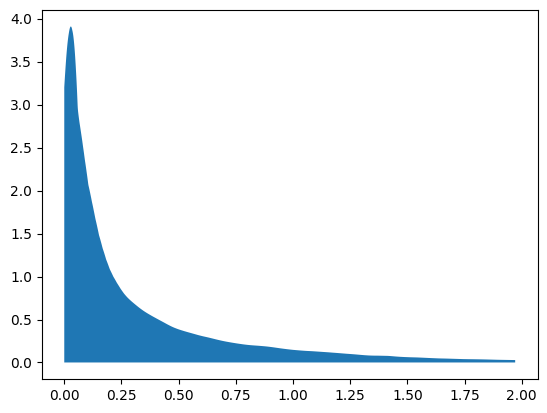

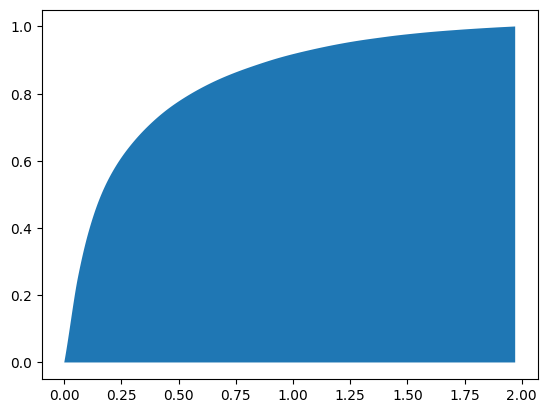

In [113]:
samples = STATE_GLOBAL['arrival_dt']/NS_TO_S
pctl = (samples).describe(percentiles=PERCENTILES)
print(pctl)
probs_from_samples(samples.values,xl=0,xr=pctl['95%'],n_size=700,plot=True,plot_xlog=False,random_state=420, kernel='epanechnikov');

count    1.980951e+06
mean     6.106157e-01
std      2.229057e+00
min      0.000000e+00
50%      1.443369e-01
75%      4.812805e-01
90%      1.172096e+00
95%      2.047089e+00
99%      8.354894e+00
99.9%    3.181887e+01
max      1.202443e+02
dtype: float64


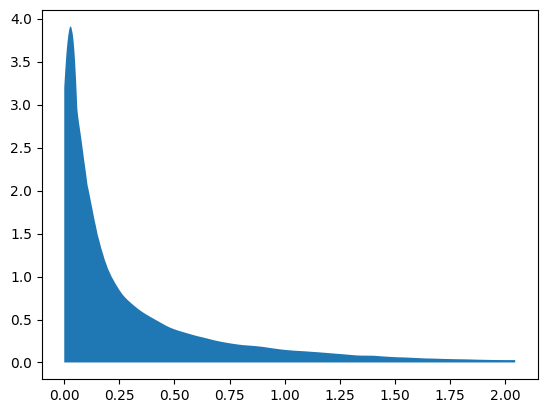

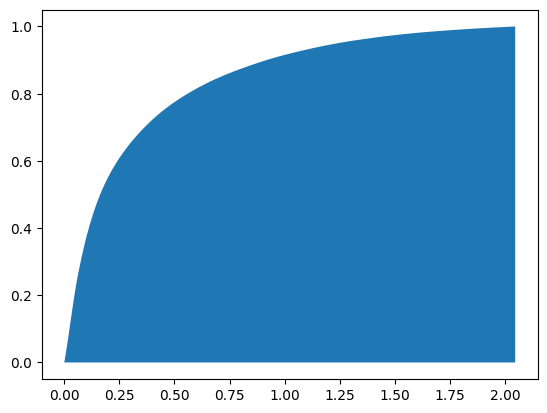

In [114]:
samples = STATE_GLOBAL['arrival_dt']/NS_TO_S
pctl = (samples).describe(percentiles=PERCENTILES)
print(pctl)
probs_from_samples(samples.values,xl=0,xr=pctl['95%'],n_size=700,plot=True,plot_xlog=False,random_state=420, kernel='epanechnikov');

In [13]:
# @dataclass
# class Bucket:
#     level = 0
#     timestamp: int 
#     functionID: int
#     applicationID: int
#     count: int
#     lastArrivalDt: float
#     lastDepartureDt: float
#     avgCount: Optional[float] = 0
#     maxCount: Optional[int] = 0   
#     arrivalCount: Optional[int] = 0
#     departureCount: Optional[int] = 0
#     avgRunningAge: Optional[float] = 0
#     virtualColdStarts: Optional[int] = 0
#     idlePc: Optional[float] = 0

# @dataclass
# class AppBucket:
#     level = 1
#     timestamp: int 
#     applicationID: int
#     count: int
#     lastArrivalDt: float
#     lastDepartureDt: float
#     avgCount: Optional[float] = 0
#     maxCount: Optional[int] = 0   
#     arrivalCount: Optional[int] = 0
#     departureCount: Optional[int] = 0
#     avgRunningAge: Optional[float] = 0
#     virtualColdStarts: Optional[int] = 0
#     idlePc: Optional[float] = 0

# @dataclass
# class GlobalBucket:
#     level = 2
#     timestamp: int 
#     count: int
#     lastArrivalDt: float
#     lastDepartureDt: float
#     avgCount: Optional[float] = 0
#     maxCount: Optional[int] = 0   
#     arrivalCount: Optional[int] = 0
#     departureCount: Optional[int] = 0
#     avgRunningAge: Optional[float] = 0
#     virtualColdStarts: Optional[int] = 0
#     idlePc: Optional[float] = 0

In [14]:
# buckets = [dict(),]*(EXECUTION_DURATION_S+1)
# buckets[0]['global'] = GlobalBucket(0, 0, 0, 0)
# for grp in range(1, len(buckets)):
#     df_grp = DF[DF['group'] == grp]
#     bucket = buckets[grp]
    
#     for event in df_grp.itertuples():
        
#         if STATE['func'][event.func_id]['count'] == None:
#             pass #init func
#             if STATE['app'][event.app_id]['count'] == None:
#                 pass #init app
#                 if STATE['global']['count'] == None:
#                    STATE['global']['current_requests'].add(event.req)
#                    STATE['global']['count'] = 0 
            
#         if event.func_id not in bucket:

#             func_state = STATE['func'][event.func_id]
#             bucket[event.func_id] = Bucket(event.ts, event.func_id, event.app_id,
                                           
                                        
#         else:
#             pass # departure